# Churn Analysis

In [1]:
import sys
sys.path.insert(0, '../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from churn_prediction.data_loader import load_events, clean_data, identify_churned_users, create_user_features

plt.style.use('seaborn-v0_8-whitegrid')

Matplotlib is building the font cache; this may take a moment.


## Load Data

In [2]:
df_raw = load_events('../data/raw/customer_churn_mini.json')
print(f'Total events: {len(df_raw):,}')
df_raw.head()

Total events: 286,500


,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,userAgent,lastName,firstName,registration,gender,artist,song,length
0,2018-10-01 00:01:57,30,29,NextSong,Logged In,PUT,200,paid,50,"Bakersfield, CA",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,Freeman,Colin,2018-09-28 22:22:42,M,Martha Tilston,Rockpools,277.89016
1,2018-10-01 00:03:00,9,8,NextSong,Logged In,PUT,200,free,79,"Boston-Cambridge-Newton, MA-NH","""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",Long,Micah,2018-09-30 18:20:30,M,Five Iron Frenzy,Canada,236.09424
2,2018-10-01 00:06:34,30,29,NextSong,Logged In,PUT,200,paid,51,"Bakersfield, CA",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,Freeman,Colin,2018-09-28 22:22:42,M,Adam Lambert,Time For Miracles,282.82730
3,2018-10-01 00:06:56,9,8,NextSong,Logged In,PUT,200,free,80,"Boston-Cambridge-Newton, MA-NH","""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",Long,Micah,2018-09-30 18:20:30,M,Enigma,Knocking On Forbidden Doors,262.71302
4,2018-10-01 00:11:16,30,29,NextSong,Logged In,PUT,200,paid,52,"Bakersfield, CA",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,Freeman,Colin,2018-09-28 22:22:42,M,Daft Punk,Harder Better Faster Stronger,223.60771


In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286500 entries, 0 to 286499
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   ts             286500 non-null  datetime64[ns]
 1   userId         286500 non-null  object        
 2   sessionId      286500 non-null  int64         
 3   page           286500 non-null  object        
 4   auth           286500 non-null  object        
 5   method         286500 non-null  object        
 6   status         286500 non-null  int64         
 7   level          286500 non-null  object        
 8   itemInSession  286500 non-null  int64         
 9   location       278154 non-null  object        
 10  userAgent      278154 non-null  object        
 11  lastName       278154 non-null  object        
 12  firstName      278154 non-null  object        
 13  registration   278154 non-null  datetime64[ns]
 14  gender         278154 non-null  object        
 15  

In [4]:
# missing values
df_raw.isnull().sum().sort_values(ascending=False).head(10)

length          58392
song            58392
artist          58392
userAgent        8346
gender           8346
registration     8346
firstName        8346
lastName         8346
location         8346
userId              0
dtype: int64

In [5]:
# empty userId?
print(f"Rows without userId: {(df_raw['userId'] == '').sum()}")

Rows without userId: 8346


In [6]:
df = clean_data(df_raw)
print(f'After cleaning: {len(df):,}')

/Users/ghaliah/churn-prediction/notebooks/../src/churn_prediction/data_loader.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["userId"] = df["userId"].astype(str)


After cleaning: 278,154


## Event Types

In [7]:
df['page'].value_counts()

page
NextSong                     228108
Thumbs Up                     12551
Home                          10082
Add to Playlist                6526
Add Friend                     4277
Roll Advert                    3933
Logout                         3226
Thumbs Down                    2546
Downgrade                      2055
Settings                       1514
Help                           1454
Upgrade                         499
About                           495
Save Settings                   310
Error                           252
Submit Upgrade                  159
Submit Downgrade                 63
Cancel                           52
Cancellation Confirmation        52
Name: count, dtype: int64

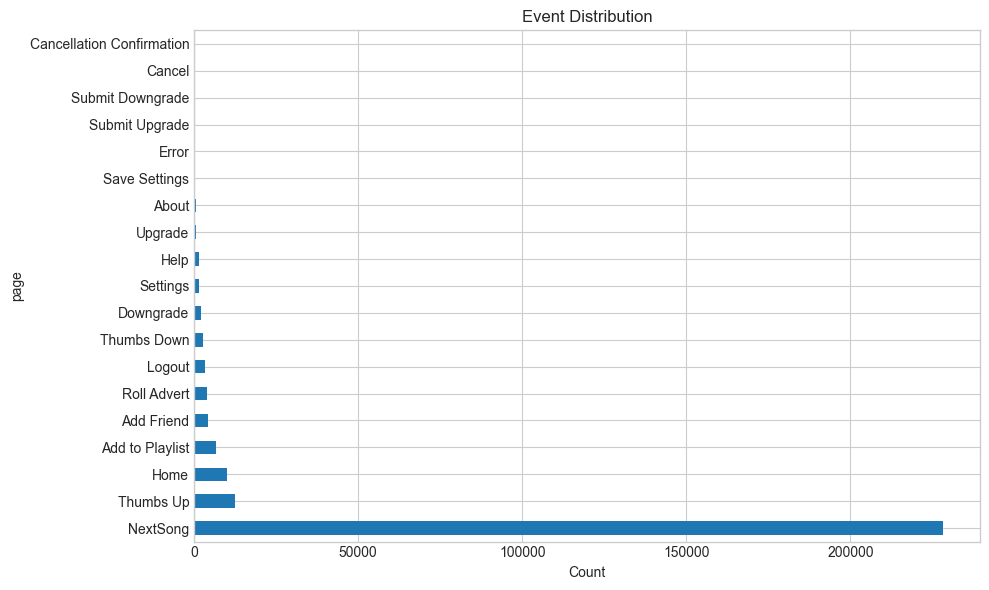

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))
df['page'].value_counts().plot(kind='barh', ax=ax)
ax.set_xlabel('Count')
ax.set_title('Event Distribution')
plt.tight_layout()

## Define Churn

User is churned if they reached "Cancellation Confirmation" page.

In [9]:
churned_users = identify_churned_users(df)
total_users = df['userId'].nunique()

print(f'Total users: {total_users}')
print(f'Churned: {len(churned_users)}')
print(f'Churn rate: {len(churned_users)/total_users*100:.1f}%')

Total users: 225
Churned: 52
Churn rate: 23.1%


In [10]:
# ~22% churn rate, will need to handle class imbalance

## Feature Engineering

In [11]:
df_features = create_user_features(df, churned_users)
df_features.head(10)

,userId,n_sessions,n_songs,n_thumbs_up,n_thumbs_down,n_add_playlist,n_add_friend,n_errors,n_help,n_downgrade,n_adverts,days_active,total_listen_time,songs_per_session,thumbs_ratio,is_paid,is_male,churned
0,10,6,673,37,4,9,12,0,1,7,1,43,166866.37251,112.166667,0.902439,1,1,0
1,100,35,2682,148,27,61,49,3,18,30,25,59,672877.85659,76.628571,0.845714,1,1,0
2,100001,4,133,8,2,3,2,1,1,0,14,2,35073.74215,33.250000,0.800000,0,0,1
3,100002,4,195,5,0,5,1,0,0,2,3,56,49559.91810,48.750000,1.000000,1,0,0
4,100003,2,51,3,0,2,0,0,1,0,9,3,12306.41932,25.500000,1.000000,0,0,1
5,100004,21,942,35,11,23,19,2,6,10,86,57,231480.38929,44.857143,0.760870,1,0,0
6,100005,5,154,7,3,3,3,0,2,0,18,19,37037.12201,30.800000,0.700000,0,1,1
7,100006,1,26,2,2,1,4,0,0,0,3,1,5854.89105,26.000000,0.500000,0,0,1
8,100007,9,423,19,6,9,17,0,3,7,5,59,104495.32492,47.000000,0.760000,1,0,1
9,100008,6,772,37,6,30,17,0,6,10,20,49,191396.79602,128.666667,0.860465,0,0,0


In [12]:
df_features.describe()

,n_sessions,n_songs,n_thumbs_up,n_thumbs_down,n_add_playlist,n_add_friend,n_errors,n_help,n_downgrade,n_adverts,days_active,total_listen_time,songs_per_session,thumbs_ratio,is_paid,is_male,churned
count,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,2.250000e+02,225.000000,225.000000,225.000000,225.000000,225.000000
mean,14.115556,1013.813333,55.782222,11.315556,29.004444,19.008889,1.120000,6.462222,9.133333,17.480000,42.115556,2.525583e+05,69.002331,0.808471,0.644444,0.537778,0.231111
std,14.646885,1104.960779,65.477925,13.077481,32.716654,20.581717,1.472607,7.242585,11.734412,21.550207,18.967900,2.753964e+05,42.320954,0.162747,0.479749,0.499682,0.422483
min,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.916688e+02,3.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,230.000000,11.000000,2.000000,6.000000,5.000000,0.000000,1.000000,0.000000,3.000000,30.000000,5.763318e+04,35.857143,0.782178,0.000000,0.000000,0.000000
50%,10.000000,675.000000,35.000000,7.000000,17.000000,14.000000,1.000000,5.000000,5.000000,11.000000,50.000000,1.680938e+05,64.200000,0.842105,1.000000,1.000000,0.000000
75%,18.000000,1571.000000,81.000000,16.000000,44.000000,27.000000,2.000000,9.000000,13.000000,22.000000,58.000000,3.924015e+05,91.714286,0.893617,1.000000,1.000000,0.000000
max,107.000000,8002.000000,437.000000,75.000000,240.000000,143.000000,7.000000,46.000000,73.000000,128.000000,61.000000,1.991155e+06,286.666667,1.000000,1.000000,1.000000,1.000000


## Class Imbalance

Text(0.5, 1.0, 'Class Distribution')

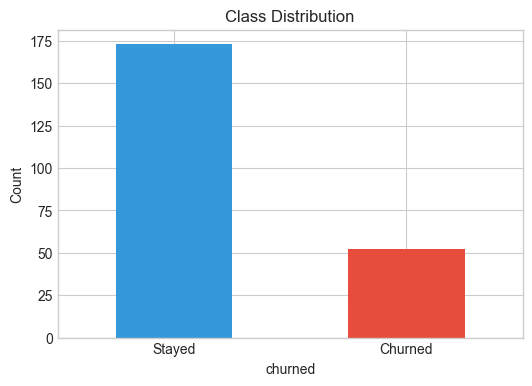

In [13]:
fig, ax = plt.subplots(figsize=(6, 4))
df_features['churned'].value_counts().plot(kind='bar', ax=ax, color=['#3498db', '#e74c3c'])
ax.set_xticklabels(['Stayed', 'Churned'], rotation=0)
ax.set_ylabel('Count')
ax.set_title('Class Distribution')

Imbalanced classes. Need to use scale_pos_weight or class_weight.

## Feature Comparison

In [14]:
comparison = df_features.groupby('churned').mean(numeric_only=True).T
comparison.columns = ['Stayed', 'Churned']
comparison['Diff %'] = (comparison['Churned'] - comparison['Stayed']) / comparison['Stayed'] * 100
comparison.sort_values('Diff %', ascending=False)

,Stayed,Churned,Diff %
is_male,0.514451,0.615385,19.619706
n_adverts,17.144509,18.596154,8.467114
is_paid,0.658960,0.596154,-9.531039
thumbs_ratio,0.829565,0.738292,-11.002574
songs_per_session,71.165085,61.807014,-13.149807
n_thumbs_down,11.849711,9.538462,-19.504690
n_sessions,15.254335,10.326923,-32.301717
n_help,7.023121,4.596154,-34.556822
n_downgrade,9.930636,6.480769,-34.739635
n_songs,1108.173410,699.884615,-36.843403


In [15]:
# churned users have more thumbs down, more help page visits
# stayed users listen to way more songs

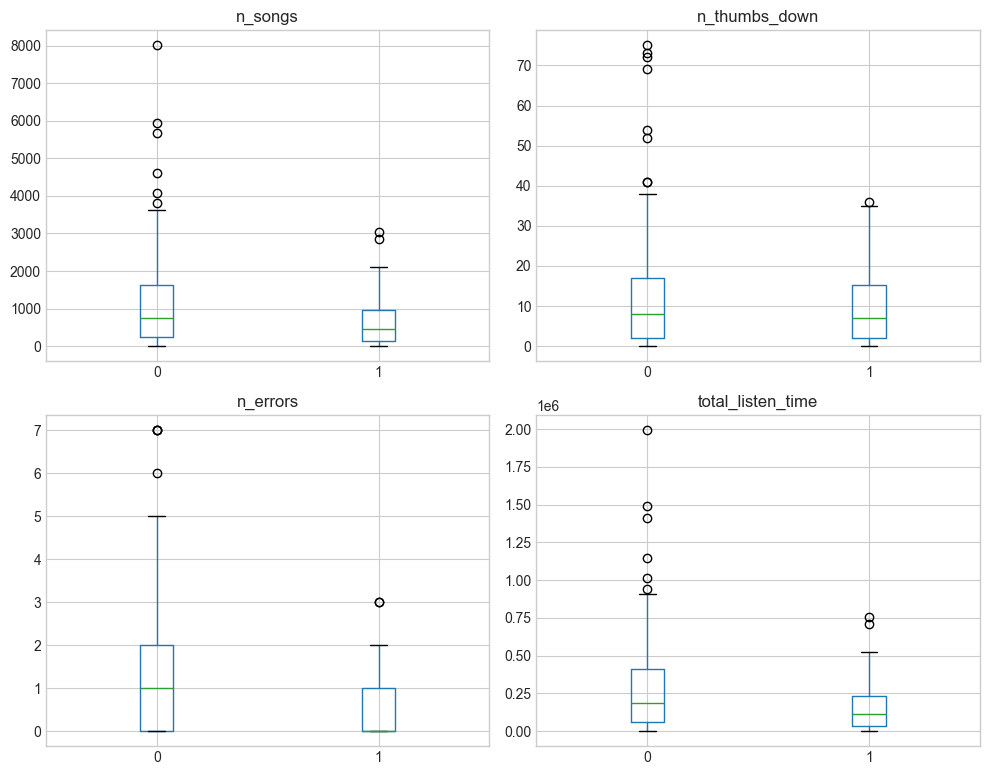

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for ax, col in zip(axes.flat, ['n_songs', 'n_thumbs_down', 'n_errors', 'total_listen_time']):
    df_features.boxplot(column=col, by='churned', ax=ax)
    ax.set_xlabel('')
    ax.set_title(col)

plt.suptitle('')
plt.tight_layout()

## Correlation

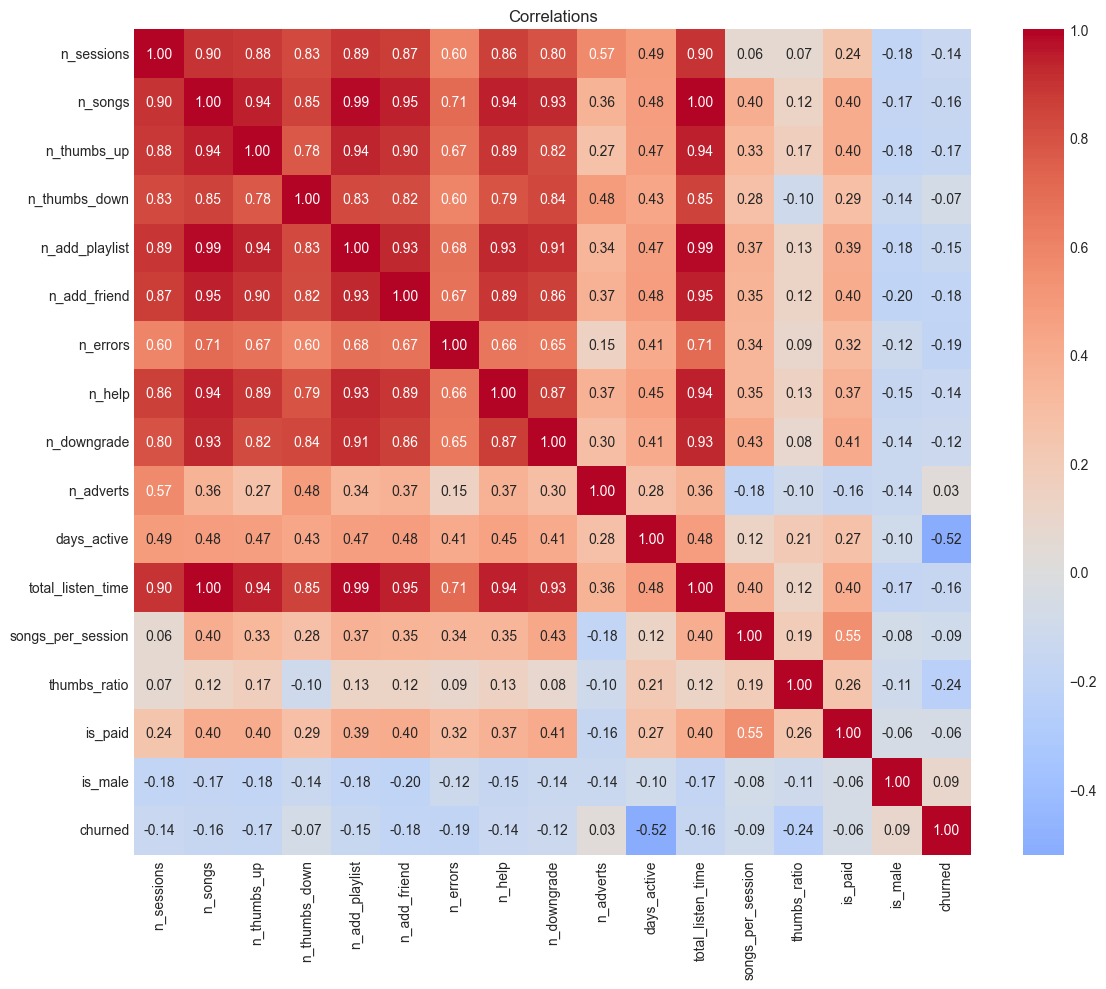

In [17]:
numeric_cols = df_features.select_dtypes(include=[np.number]).columns
corr = df_features[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlations')
plt.tight_layout()

In [18]:
# correlation with churn
corr['churned'].drop('churned').sort_values()

days_active         -0.520882
thumbs_ratio        -0.236942
n_errors            -0.188287
n_add_friend        -0.180956
n_thumbs_up         -0.168105
total_listen_time   -0.156712
n_songs             -0.156110
n_add_playlist      -0.151875
n_sessions          -0.142129
n_help              -0.141573
n_downgrade         -0.124208
songs_per_session   -0.093420
n_thumbs_down       -0.074668
is_paid             -0.055309
n_adverts            0.028459
is_male              0.085340
Name: churned, dtype: float64

## Summary

- Churn rate ~22%
- Imbalanced classes - use scale_pos_weight
- Key indicators: n_songs, thumbs_down, errors
- Paid users less likely to churn